In [ ]:
import numpy as np


In [1]:
import numpy as np
import tensorflow as tf

import os

from tensorflow.python.platform import app
from tensorflow.python.platform import flags

from prediction_input import build_tfrecord_input
from prediction_model import construct_model

# How often to record tensorboard summaries.
SUMMARY_INTERVAL = 40

# How often to run a batch through the validation model.
VAL_INTERVAL = 200

# How often to save a model checkpoint
SAVE_INTERVAL = 2000

# tf record data location:
DATA_DIR = '/cs/vml4/xca64/robot_data/push//push_train'

# local output directory
OUT_DIR = '/cs/vml4/xca64/robot_data/checkpoints'

FLAGS = flags.FLAGS


flags.DEFINE_string('gif_dir', '/cs/vml4/xca64/robot_data/gif/', 'directory containing data.')
flags.DEFINE_string('data_dir', DATA_DIR, 'directory containing data.')
flags.DEFINE_string('output_dir', OUT_DIR, 'directory for model checkpoints.')
flags.DEFINE_string('event_log_dir',OUT_DIR+'/summaries', 'directory for writing summary.')
flags.DEFINE_integer('num_iterations', 100000, 'number of training iterations.')
flags.DEFINE_string('pretrained_model','/cs/vml4/xca64/robot_data/checkpoints2/model2002' ,
                    'filepath of a pretrained model to initialize from.')

flags.DEFINE_integer('sequence_length', 10,
                     'sequence length, including context frames.')
flags.DEFINE_integer('context_frames', 2, '# of frames before predictions.')
flags.DEFINE_integer('use_state', 1,
                     'Whether or not to give the state+action to the model')

flags.DEFINE_string('model', 'CDNA',
                    'model architecture to use - CDNA, DNA, or STP')

flags.DEFINE_integer('num_masks', 10,
                     'number of masks, usually 1 for DNA, 10 for CDNA, STN.')
flags.DEFINE_float('schedsamp_k', 900.0,
                   'The k hyperparameter for scheduled sampling,'
                   '-1 for no scheduled sampling.')
flags.DEFINE_float('train_val_split', 0.95,
                   'The percentage of files to use for the training set,'
                   ' vs. the validation set.')

flags.DEFINE_integer('batch_size', 32, 'batch size for training')
flags.DEFINE_float('learning_rate', 0.001,
                   'the base learning rate of the generator')

import moviepy.editor as mpy
def npy_to_gif(npy, filename):
     clip = mpy.ImageSequenceClip(list(npy), fps=10)
     clip.write_gif(filename)

## Helper functions
def peak_signal_to_noise_ratio(true, pred):
  """Image quality metric based on maximal signal power vs. power of the noise.

  Args:
    true: the ground truth image.
    pred: the predicted image.
  Returns:
    peak signal to noise ratio (PSNR)
  """
  return 10.0 * tf.log(1.0 / mean_squared_error(true, pred)) / tf.log(10.0)


def mean_squared_error(true, pred):
  """L2 distance between tensors true and pred.

  Args:
    true: the ground truth image.
    pred: the predicted image.
  Returns:
    mean squared error between ground truth and predicted image.
  """
  return tf.reduce_sum(tf.square(true - pred)) / tf.to_float(tf.size(pred))


class Model(object):

  def __init__(self,
               images=None,
               actions=None,
               states=None,
               sequence_length=None,
               reuse_scope=None):

    if sequence_length is None:
      sequence_length = FLAGS.sequence_length

    self.prefix = prefix = tf.placeholder(tf.string, [])
    self.iter_num = tf.placeholder(tf.float32, [])
    summaries = []

    # Split into timesteps.
    actions = tf.split(actions, actions.get_shape().as_list()[1],1)
    actions = [tf.squeeze(act) for act in actions]          
    
    states = tf.split( states, states.get_shape().as_list()[1],1)
    states = [tf.squeeze(st) for st in states]

    images = tf.split(images, images.get_shape().as_list()[1],1 )
    images = [tf.squeeze(img) for img in images]
  
    if reuse_scope is None:
      gen_images, gen_states = construct_model(
          images,
          actions,
          states,
          iter_num=self.iter_num,
          k=FLAGS.schedsamp_k,
          use_state=FLAGS.use_state,
          num_masks=FLAGS.num_masks,
          cdna=FLAGS.model == 'CDNA',
          dna=FLAGS.model == 'DNA',
          stp=FLAGS.model == 'STP',
          context_frames=FLAGS.context_frames)
    else:  # If it's a validation or test model.
      with tf.variable_scope(reuse_scope, reuse=True):
        gen_images, gen_states = construct_model(
            images,
            actions,
            states,
            iter_num=self.iter_num,
            k=FLAGS.schedsamp_k,
            use_state=FLAGS.use_state,
            num_masks=FLAGS.num_masks,
            cdna=FLAGS.model == 'CDNA',
            dna=FLAGS.model == 'DNA',
            stp=FLAGS.model == 'STP',
            context_frames=FLAGS.context_frames)

    # L2 loss, PSNR for eval.
    loss, psnr_all = 0.0, 0.0

    self.gen_images=gen_images
    self.images = images
    try:
       tf.equal(prefix,'train').eval()
    except:
       prefixs='initial'
    else:
       if tf.equal(prefix,'train').eval():
           prefixs='train'
       else:
           prefixs='val'

    for i, x, gx in zip(
        range(len(gen_images)), images[FLAGS.context_frames:],
        gen_images[FLAGS.context_frames - 1:]):
      recon_cost = mean_squared_error(x, gx)
      psnr_i = peak_signal_to_noise_ratio(x, gx)
      psnr_all += psnr_i

      summaries.append(
          tf.summary.scalar(prefixs + '_recon_cost' + str(i), recon_cost))

      summaries.append(tf.summary.scalar(prefixs + '_psnr' + str(i), psnr_i))
      
      loss += recon_cost

    for i, state, gen_state in zip(
        range(len(gen_states)), states[FLAGS.context_frames:],
        gen_states[FLAGS.context_frames - 1:]):
      state_cost = mean_squared_error(state, gen_state) * 1e-4
      summaries.append(
          tf.summary.scalar(prefixs + '_state_cost' + str(i), state_cost))
      loss += state_cost
    summaries.append(tf.summary.scalar(prefixs + '_psnr_all', psnr_all))
    self.psnr_all = psnr_all

    self.loss = loss = loss / np.float32(len(images) - FLAGS.context_frames)

    summaries.append(tf.summary.scalar(prefixs + '_loss', loss))

    self.lr = tf.placeholder_with_default(FLAGS.learning_rate, ())

    self.train_op = tf.train.AdamOptimizer(self.lr).minimize(loss)
    self.summ_op = tf.summary.merge(summaries)


tf.logging.set_verbosity(tf.logging.INFO)

# with tf.Graph().as_default():
print('Constructing models and inputs.')
with tf.variable_scope('model', reuse=None) as training_scope:
  images, actions, states = build_tfrecord_input(training=True)
  model = Model(images, actions, states, FLAGS.sequence_length)


print('Constructing saver.')
# Make saver.

# Make training session.
sess = tf.InteractiveSession()
sess = tf.Session()
summary_writer = tf.summary.FileWriter(
    FLAGS.event_log_dir, graph=sess.graph, flush_secs=10)

saver = tf.train.Saver(
    tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES), max_to_keep=0)
if FLAGS.pretrained_model:
  saver.restore(sess, FLAGS.pretrained_model)

tf.train.start_queue_runners(sess)
sess.run(tf.global_variables_initializer())

tf.logging.info('iteration number, cost')

print('Start Tranning')
# Run training.
# for itr in range(FLAGS.num_iterations):
  # print('In iteration ', itr)
  # Generate new batch of data.
itr=1
feed_dict = {model.prefix: 'train',
            model.iter_num: np.float32(itr),
            model.lr: FLAGS.learning_rate}
cost, _, summary_str, gen_images, images = sess.run([model.loss, model.train_op, model.summ_op, model.gen_images, model.images],
                                feed_dict)
print('Gen Images', np.shape(images))

Constructing models and inputs.
Constructing saver.
INFO:tensorflow:iteration number, cost
Start Tranning
('Gen Images', (10, 32, 64, 64, 3))


In [ ]:
print((images[0][1]))

In [14]:
%matplotlib inline


In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

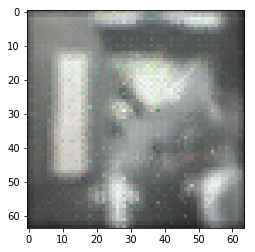

In [24]:
plt.imshow(gen_images[0][11])
# plt.imshow(images[0][11])

In [51]:
im_array = np.asarray(images)

In [52]:
print(np.min(im_array))

0.0


In [46]:
print(type(im_array), np.shape(im_array))

(<type 'numpy.ndarray'>, (9, 32, 64, 64, 3))


In [47]:
ims = np.transpose(im_array,(1,0,2,3,4))

(9, 64, 64, 3)


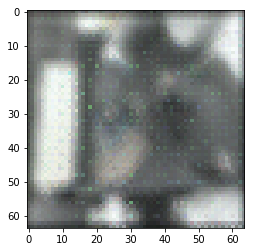

In [48]:
print(np.shape(ims[0]))
plt.imshow(ims[0][2])

In [50]:
npy_to_gif(ims[1]*255, '/cs/vml4/xca64/robot_data/gif/gen_test' + '.gif')


[MoviePy] Building file /cs/vml4/xca64/robot_data/gif/gen_test.gif with imageio


 90%|█████████ | 9/10 [00:00<00:00, 130.34it/s]


In [ ]:
# images = np.transpose(images,(1,0,2,3,4))
    # Print info: iteration #, cost.
    tf.logging.info('  In Iteration ' + str(itr) + ', Cost ' + str(cost))
    for i in range(2):
        video = images[i]

        filename='/cs/vml4/xca64/robot_data/gif/gen_' + str(i) + '.gif'
        print(filename)
        npy_to_gif(video, '/cs/vml4/xca64/robot_data/gif/gen_' + str(i) + '.gif')
